In [12]:

# heatmap plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colors
from pathlib import Path

In [13]:
report_dir = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT/kinase_results_before_adding_gene_names'
sample_annotation_path = "/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches/patient_annotation_paper_cohort_230626_final.csv"

In [14]:
patients_list = [
                'H021-W3ZFUV-T1-E1',
                'H021-UJBX-M4-Q1',
                'H021-8DSJKN-T1-Q1',
                'H021-3CX96H-T1',
                'H021-M9ZE3G-M1-E1'
                ]
meta_data_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_MTBs_Evaluation/Metadata_Papercohort_230801.xlsx'
meta_data = pd.read_excel(meta_data_path)
meta = meta_data[meta_data['Sample name'].isin(patients_list)][['Sample name', 'Paper_pseudo_identifier']].set_index('Sample name').to_dict()['Paper_pseudo_identifier']

In [15]:
kinase = "EGFR"
pep_kinase_scores_path = Path(report_dir)/Path('scored_peptides.tsv')
kinase_Scores_path = Path(report_dir)/Path('kinase_scores.tsv')
pep_kinase_Scores_df = pd.read_csv(pep_kinase_scores_path,sep='\t')
#pep_kinase_Scores_df['Modified sequence'] = pep_kinase_Scores_df['PSP Kinases'] + ':' + pep_kinase_Scores_df['Modified sequence']
kinase_scores_df = pd.read_csv(kinase_Scores_path,sep='\t')

In [16]:
sample_annotation_df = pd.read_csv(sample_annotation_path)
sample_annotation_df = sample_annotation_df[['Sample name','Batch Name']]
new_pep_kinase_scores_df = pep_kinase_Scores_df.set_index('Modified sequence')
new_pep_kinase_scores_df = new_pep_kinase_scores_df.filter(regex='pat_')
new_pep_kinase_scores_df.columns = new_pep_kinase_scores_df.columns.str.replace('pat_','')
new_pep_kinase_scores_df =  new_pep_kinase_scores_df.T
new_pep_kinase_scores_df = new_pep_kinase_scores_df.merge(sample_annotation_df,right_on='Sample name',left_index=True)
new_pep_kinase_scores_df = new_pep_kinase_scores_df.set_index('Batch Name')
def get_num_batch_pep(peptide):
    test = new_pep_kinase_scores_df[peptide]
    test = test.dropna()
    ans = 0
    if len(test) > 0:
        ans = len(test.index.unique())
    return ans

In [17]:

def get_kinase_score_and_related_peptides_scores(pep_kinase_Scores_df:pd.DataFrame,
                                                kinase_scores_df:pd.DataFrame,
                                                kinase_of_interest:str,
                                                patients_list:list)-> pd.DataFrame:
    """ 
    Gets the kinase scors and peptides scores from the kinase for a kinase and list of patients
    kinase_scores.tsv  scored_peptides.tsv
    :pep_kinase_Scores_df:  scored_peptides.tsv
    :kinase_scores_df: kinase_scores.tsv
    :kinase_of_interest: like EGFR
    :patients_list: a list of patients
    """
    pep_kinase_Scores_df = pep_kinase_Scores_df[pep_kinase_Scores_df['PSP Kinases'] == kinase_of_interest]
    kinase_scores_df = kinase_scores_df[kinase_scores_df['PSP Kinases'] == kinase_of_interest]
    pep_kinase_Scores_df = pep_kinase_Scores_df.set_index('Modified sequence')
    kinase_scores_df = kinase_scores_df.set_index('PSP Kinases')
    
    pep_kinase_Scores_df = pep_kinase_Scores_df.filter(regex='pat_')
    pep_kinase_Scores_df.columns = pep_kinase_Scores_df.columns.str.replace('pat_','')
    pep_kinase_Scores_df = pep_kinase_Scores_df[patients_list]   
    
    kinase_scores_df = kinase_scores_df[patients_list]
    if all(kinase_scores_df.columns == pep_kinase_Scores_df.columns):
        final_df = pd.concat([pep_kinase_Scores_df,kinase_scores_df])
    return final_df



In [18]:
df = get_kinase_score_and_related_peptides_scores(pep_kinase_Scores_df,kinase_scores_df,'EGFR',patients_list)

In [19]:
final_pepe_list =  [x for x in df.index.tolist() if x in new_pep_kinase_scores_df.columns]
pep_batch_count = list(map(get_num_batch_pep,final_pepe_list))
df_pep_batch = pd.DataFrame(list(zip(final_pepe_list,pep_batch_count)),columns=['peptides_lists','counts'])
df_removing_pep_batch = df_pep_batch['peptides_lists'][df_pep_batch['counts'] <= 1].tolist()
df = df[~df.index.isin(df_removing_pep_batch)]
min_df = df.min().min()
df = df.fillna(-4)

In [20]:

df = df.loc[:,patients_list]
df.columns = df.columns.map(meta)

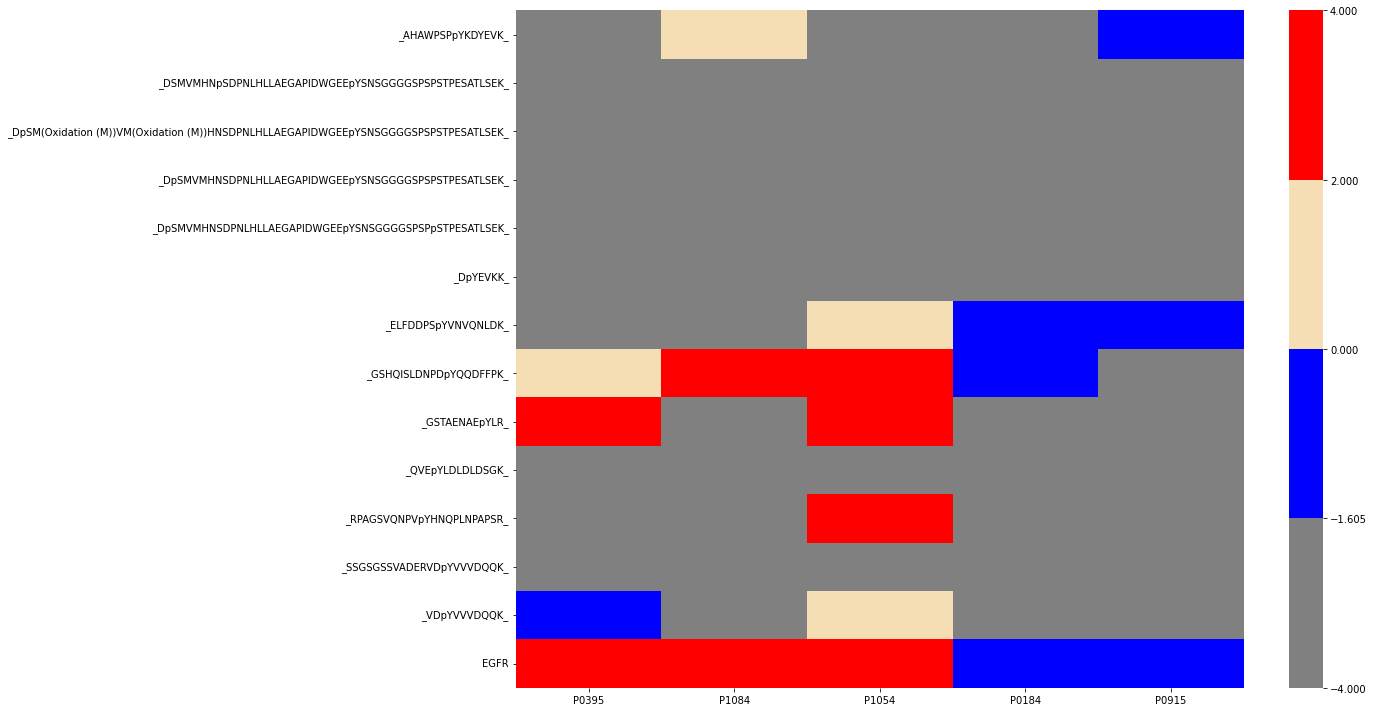

In [23]:

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True



cmap = colors.ListedColormap(['grey','blue','wheat','red'])

bounds = [-4,min_df,0,2,4]
norm = colors.BoundaryNorm(bounds,cmap.N)
# plot heatmap
sns.heatmap(df,cmap=cmap,norm=norm)

plt.savefig('kinase_scores.svg')
plt.show()